# HA-ES Plotting

- udpated version of plotting script used for paper "..."

## General

- imports
- defintions
- loading data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygmo as pg
import seaborn as sns

import math
import os

from autorank._util import get_sorted_rank_groups
from autorank import autorank, plot_stats
from tabrepo import load_repository

method_id_name_dict = {
    "GES": "GES*",
    "SINGLE_BEST": "Single-Best",
    "QO": "QO-ES",
    "QDO": "QDO-ES",
    "ENS_SIZE_QDO": "Ensemble Size",
    "INFER_TIME_QDO": "Inference Time",
    "MEMORY_QDO": "HAPEns",
    #"MEMORY_QDO": "Memory",
    "DISK_QDO": "Diskspace",
}
infer_time_weights = np.linspace(0, 1, num=20)[1:]
infer_time_weights = np.round(infer_time_weights, 2)
multi_ges_method_ids = [f"MULTI_GES-{time_weight:.2f}" for time_weight in infer_time_weights]
multi_ges_method_names = [f"Multi-GES({time_weight:.2f})" for time_weight in infer_time_weights]
for id, name in zip(multi_ges_method_ids, multi_ges_method_names):
    method_id_name_dict[id] = name

print("Loading data. This might take a while...")
df = pd.read_json("../data/full.json")

# Map method IDs to names
if "method" in df.columns:
    df["method_name"] = df["method"].map(method_id_name_dict)
else:
    raise ValueError("Column 'method' not found in DataFrame")
df = df.dropna(subset=['method_name'])
print(df.shape)
print(df.columns)
print(df["method_name"].unique())
print(df["method"].unique())

df["models_used_length"] = df["models_used"].apply(len)

if True:
    print("Filtering methods...")
    filter_methods = [
        "Single-Best",
        "GES*",
        "QDO-ES",
        "HAPEns",
        # "Memory",
        "Ensemble Size",
        "Inference Time",
        # "Diskspace",
        "Multi-GES(0.21)",
        "Multi-GES(0.79)"
    ]
    df = df[df['method_name'].isin(filter_methods)]
    print(df.shape)
    print(df.columns)
    print(df["method_name"].unique())
    print(df["method"].unique())

Loading data. This might take a while...
(83375, 21)
Index(['name', 'roc_auc_val', 'roc_auc_test', 'task_id', 'fold', 'models_used',
       'weights', 'method', 'dataset', 'task', 'seed', 'iteration',
       'time_weight', 'inference_time', 'memory', 'diskspace',
       'normalized_roc_auc_val', 'normalized_roc_auc_test', 'normalized_time',
       'normalized_memory', 'method_name'],
      dtype='object')
['Single-Best' 'HAPEns' 'QDO-ES' 'Ensemble Size' 'Inference Time'
 'Multi-GES(0.21)' 'Multi-GES(0.79)' 'GES*' 'Diskspace']
['SINGLE_BEST' 'MEMORY_QDO' 'QDO' 'ENS_SIZE_QDO' 'INFER_TIME_QDO'
 'MULTI_GES-0.21' 'MULTI_GES-0.79' 'GES' 'DISK_QDO']
Filtering methods...
(71281, 22)
Index(['name', 'roc_auc_val', 'roc_auc_test', 'task_id', 'fold', 'models_used',
       'weights', 'method', 'dataset', 'task', 'seed', 'iteration',
       'time_weight', 'inference_time', 'memory', 'diskspace',
       'normalized_roc_auc_val', 'normalized_roc_auc_test', 'normalized_time',
       'normalized_memory'

## Helper Functions

### Boxplot:

In [2]:
import re
import ipywidgets as widgets

def extract_numeric_part(method_name):
    """
    Extracts the numeric part from a method name string. If no numeric part is found, returns None.
    """
    if isinstance(method_name, str):
        match = re.search(r"\((\d*\.?\d+)\)", method_name)
        if match:
            return float(match.group(1))
    return None

def boxplot(
    df: pd.DataFrame,
    y_str: str,
    log_y_scale: bool = False,
    log_x_scale: bool = False,
    flip_y_axis: bool = False,
    orient: str = "v",
    rotation_x_ticks: int = 45,
    outliers=False,
    sort_by_median: bool = True,  # <-- added flag
):
    if y_str not in df.columns:
        raise ValueError(f"Column '{y_str}' not found in DataFrame")
    
    df["method_name"] = df["method_name"].astype(str)

    if sort_by_median:
        # Sort by median of the target column
        medians = (
            df.groupby("method_name")[y_str]
            .median()
            .sort_values(ascending=False)  # largest median first
        )
        df["method_name"] = pd.Categorical(df["method_name"], categories=medians.index, ordered=True)
        df = df.sort_values("method_name")
    else:
        # Alphabetic + numeric sorting as fallback
        df["alphabetic"] = df["method_name"].apply(lambda x: re.split(r"\(\d*\.?\d+\)", x)[0])
        df["numeric"] = df["method_name"].apply(extract_numeric_part)
        df = df.sort_values(by=["alphabetic", "numeric"], ascending=[True, True])
        df = df.drop(columns=["alphabetic", "numeric"])

    plt.figure(figsize=(8, 6))
    if orient == "v":
        sns.boxplot(
            data=df,
            x="method_name",
            y=y_str,
            hue="method_name",
            palette="pastel",
            linewidth=2,
            orient=orient,
            legend=False,
            showfliers=outliers,
        )
    elif orient == "h":
        sns.boxplot(
            data=df,
            x=y_str,
            y="method_name",
            hue="method_name",
            palette="pastel",
            linewidth=2,
            orient=orient,
            legend=False,
            showfliers=outliers,
        )
    else:
        raise ValueError(f"Orient '{orient}' not supported")

    if orient == "v":
        plt.ylabel(y_str)
        plt.xlabel("Ensemble Method")
    else:
        plt.xlabel(y_str)
        plt.ylabel("Ensemble Method")

    if log_y_scale:
        plt.yscale("log")
    if log_x_scale:
        plt.xscale("log")
    if flip_y_axis:
        plt.gca().invert_yaxis()

    plt.xticks(rotation=rotation_x_ticks)
    plt.grid(True)
    plt.tight_layout()

    directory = "../plots"
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(f"{directory}/boxplot_{y_str}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{directory}/boxplot_{y_str}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

def interactive_boxplot(df, column_options):
    y_str_widget = widgets.Dropdown(
        options=column_options,
        description="Y-axis column:",
        style={"description_width": "initial"},
    )
    log_y_scale_widget = widgets.Checkbox(value=False, description="Log-scale Y-axis")
    log_x_scale_widget = widgets.Checkbox(value=False, description="Log-scale X-axis")
    flip_y_axis_widget = widgets.Checkbox(value=False, description="Flip Y-axis")
    orient_widget = widgets.RadioButtons(
        options=["v", "h"],
        value="h",
        description="Orientation:",
        style={"description_width": "initial"},
    )
    rotation_x_ticks_widget = widgets.IntSlider(
        value=0, min=0, max=90, step=5, description="Rotation X-ticks"
    )

    ui = widgets.VBox(
        [
            y_str_widget,
            log_y_scale_widget,
            log_x_scale_widget,
            flip_y_axis_widget,
            orient_widget,
            rotation_x_ticks_widget,
        ]
    )

    out = widgets.interactive_output(
        boxplot,
        {
            "df": widgets.fixed(df),
            "y_str": y_str_widget,
            "log_y_scale": log_y_scale_widget,
            "log_x_scale": log_x_scale_widget,
            "flip_y_axis": flip_y_axis_widget,
            "orient": orient_widget,
            "rotation_x_ticks": rotation_x_ticks_widget,
        },
    )

    display(ui, out)

### Critical Difference:

In [3]:
def cd_evaluation(
    hypervolumes,
    maximize_metric=True,
    plt_title="Critical Difference Plot",
    filename="CriticalDifferencePlot.png",
):
    """
    hypervolumes: DataFrame with method names as columns and tasks as rows, each cell contains hypervolume.
    maximize_metric: Boolean, True if higher values are better.
    output_path: Where to save the plot, if None, plot will not be saved.
    plt_title: Title of the plot.
    """
    # Prepare data
    rank_data = -hypervolumes if maximize_metric else hypervolumes

    # Run autorank
    result = autorank(rank_data, alpha=0.05, verbose=False, order="ascending")

    # Plot with updated font size
    plt.close("all")
    width = 6
    fig, ax = plt.subplots(figsize=(12, width))
    plt.rcParams.update({"font.size": 20})

    plot_stats(result, ax=ax)
    ax.tick_params(axis="both", labelsize=20)  # Set font size for axis ticks
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
    plt.tight_layout()

    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

    return result


## Data Exploration

In [4]:
column_options = ["models_used_length", "normalized_roc_auc_test", "normalized_roc_auc_val", "inference_time", "memory", "diskspace", "normalized_memory"]

#filtered_df = df[~df['method_name'].isin(['Multi-GES(0.43)', 'Multi-GES(0.50)'])].copy()
interactive_boxplot(df, column_options)

Output()

/tmp/ipykernel_116678/3229063242.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = df.groupby('method_name').agg(


<Figure size 1000x600 with 0 Axes>

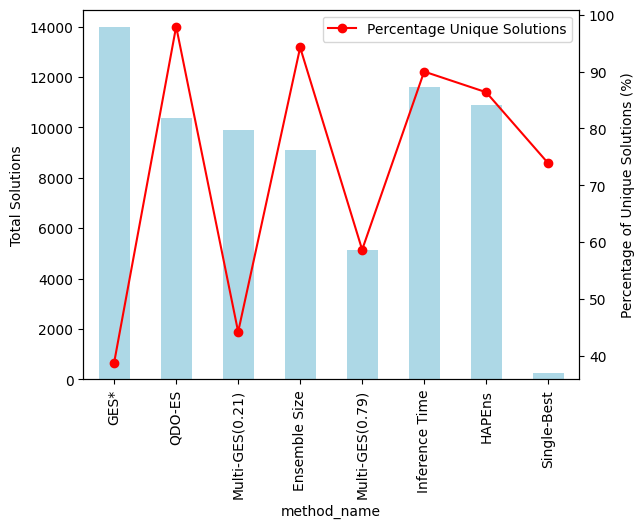

In [5]:
df['models_used_tuple'] = df['models_used'].apply(tuple)

# Group the DataFrame by 'method_name' and compute total and unique counts
result_df = df.groupby('method_name').agg(
    total_solutions=('models_used', 'count'),
    unique_solutions=('models_used_tuple', 'nunique')
)

# Calculate the percentage of unique solutions
result_df['percentage_unique_solutions'] = (
    result_df['unique_solutions'] / result_df['total_solutions'] * 100
)

# Optionally reset the index if you want 'method_name' as a column
result_df = result_df.reset_index()

# Plot the bar chart for total solutions
plt.figure(figsize=(10, 6))
ax = result_df.plot(kind='bar', x='method_name', y='total_solutions', color='lightblue', legend=False)

# Plot the percentage of unique solutions as a line graph
ax2 = ax.twinx()
ax2.plot(result_df['method_name'], result_df['percentage_unique_solutions'], color='red', marker='o', label='Percentage Unique Solutions')
ax2.set_ylabel('Percentage of Unique Solutions (%)')

# Set titles and labels
# ax.set_title("Total Solutions and Percentage of Unique Solutions per Method")
ax.set_ylabel("Total Solutions")
plt.xticks(rotation=90)
plt.legend()

plt.show()

## Pareto Front Eval

### True Pareto Front

In [6]:
def getParetoFront(df, objectives, return_mask=False):
    """
    Identify the Pareto-efficient points in the DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of objective column names.
    - return_mask: if True, return a boolean mask; else return indices.

    Returns:
    - Boolean mask or indices of Pareto-efficient points.
    """
    data = df[objectives].values
    is_efficient = np.ones(data.shape[0], dtype=bool)
    for i, c in enumerate(data):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(data[is_efficient] < c, axis=1)  # Keep any point with a lower value
            is_efficient[i] = True  # And keep self
    if return_mask:
        return is_efficient
    else:
        return np.where(is_efficient)[0]
    
def calculate_pareto_fronts(df, objectives):
    """
    Calculate the Pareto front points for all solutions in the DataFrame per task_id, seed, and fold.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of two objective column names.

    Returns:
    - A nested dictionary with structure {task_id: {seed: {fold: pareto_front_df}}}
    """
    if len(objectives) != 2:
        raise ValueError("Exactly two objectives must be provided.")

    # Initialize a dictionary to store the Pareto fronts
    pareto_fronts = {}

    # Iterate over unique task_ids
    for task_id in df["task_id"].unique():
        pareto_fronts[task_id] = {}

        # Iterate over unique seeds
        for seed in df["seed"].unique():
            pareto_fronts[task_id][seed] = {}

            # Iterate over unique folds
            for fold in df["fold"].unique():
                # Filter the DataFrame for the current task_id, seed, and fold
                df_fold = df[
                    (df["task_id"] == task_id)
                    & (df["seed"] == seed)
                    & (df["fold"] == fold)
                ]

                if df_fold.empty:
                    continue  # Skip if no data for this combination

                # Compute Pareto front for df_fold
                is_efficient = getParetoFront(df_fold, objectives, return_mask=True)
                pareto_front_df = df_fold[is_efficient]

                # Store the Pareto front DataFrame
                pareto_fronts[task_id][seed][fold] = pareto_front_df

    return pareto_fronts



def plot_pareto_fronts(pareto_fronts, df, objectives, seed_to_plot=0):
    """
    Plot Pareto fronts with outlined and semi-transparent points, only for the specified seed.

    Parameters:
    - pareto_fronts: nested dictionary with structure {task_id: {seed: {fold: pareto_front_df}}}
    - df: original DataFrame containing all points.
    - objectives: list of two objective column names.
    - seed_to_plot: the seed for which to plot Pareto fronts.
    """
    # Unpack objective names for labeling
    obj_x, obj_y = objectives

    point_size = 100  # Adjust point size as needed

    # Iterate over task_id and fold combinations for the specified seed
    for task_id, seeds in pareto_fronts.items():
        if seed_to_plot in seeds:
            for fold, pareto_front_df in seeds[seed_to_plot].items():
                # Filter out non-Pareto points
                df_fold = df[(df["task_id"] == task_id) & (df["seed"] == seed_to_plot) & (df["fold"] == fold)]
                non_pareto_df = df_fold[~df_fold.index.isin(pareto_front_df.index)]

                # Plot each Pareto front using Seaborn
                plt.figure(figsize=(10, 8))

                # Plot non-Pareto points in skyblue with a dark outline and semi-transparency
                sns.scatterplot(
                    x=non_pareto_df[obj_x],
                    y=non_pareto_df[obj_y],
                    color='skyblue',
                    edgecolor='black',
                    marker='o',
                    s=point_size,
                    alpha=0.6,
                    label='Non-Pareto points'
                )

                # Plot Pareto front points in darkred with a black outline and semi-transparency
                sns.scatterplot(
                    x=pareto_front_df[obj_x],
                    y=pareto_front_df[obj_y],
                    color='red',
                    edgecolor='black',
                    marker='o',
                    s=point_size,
                    alpha=0.8,
                    label='Pareto front points'
                )

                # Customize axis labels, title, and legend for readability
                plt.xlabel(obj_x, fontsize=14)
                plt.ylabel(obj_y, fontsize=14)
                plt.title(f'Pareto Front for Task {task_id}, Seed {seed_to_plot}, Fold {fold}', fontsize=16)
                plt.legend(fontsize=12)
                plt.grid(True)

                # Set axis limits to [0, 1]
                plt.xlim(0, 1)
                plt.ylim(0, 1)

                # Create directory if it doesn't exist and save the plot
                directory = f"../plots/pareto_fronts/{seed_to_plot}"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                plt.savefig(f"{directory}/{task_id}_{fold}.png")
                plt.close()

In [7]:
objectives = ['normalized_roc_auc_test', 'normalized_memory']

### Hypervolume

In [8]:
def is_pareto_efficient(costs, return_mask=True):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        is_efficient[i] = not np.any(
            np.all(costs <= c, axis=1) & np.any(costs < c, axis=1)
        )
    return is_efficient if return_mask else costs[is_efficient]


def calculate_average_hypervolumes(df, method_name, objectives: list = ["normalized_roc_auc", "normalized_time"]):
    if len(objectives) != 2: 
        return
    df_method = df[df["method_name"] == method_name]
    hypervolumes = {}

    # Iterate over unique task_ids
    for task_id in df_method["task_id"].unique():
        seed_hypervolumes = []  # Store hypervolumes for each seed

        for seed in df_method["seed"].unique():
            fold_hypervolumes = []  # Store hypervolumes for each fold under the current seed

            for fold in df_method["fold"].unique():
                df_fold = df_method[
                    (df_method["task_id"] == task_id)
                    & (df_method["seed"] == seed)
                    & (df_method["fold"] == fold)
                ]

                # Use a different variable name here
                objective_values = np.array(
                    [
                        df_fold[objectives[0]].values,
                        df_fold[objectives[1]].values,
                    ]
                ).T
                is_efficient = is_pareto_efficient(objective_values)
                efficient_objectives = objective_values[is_efficient]

                ref_point = [
                    1.01,
                    1.01,
                ]  # Reference point beyond the worst values of objectives
                hv = pg.hypervolume(efficient_objectives)
                hypervolume = hv.compute(ref_point)
                fold_hypervolumes.append(hypervolume)

            # Average hypervolumes across all folds for a given seed
            if fold_hypervolumes:
                average_fold_hypervolume = np.mean(fold_hypervolumes)
                seed_hypervolumes.append(average_fold_hypervolume)

        # Average the averaged fold hypervolumes across seeds
        if seed_hypervolumes:
            average_seed_hypervolume = np.mean(seed_hypervolumes)
            hypervolumes[task_id] = average_seed_hypervolume

    return hypervolumes



def find_non_dominated(points):
    """Identify the indices of non-dominated points."""
    is_efficient = np.ones(points.shape[0], dtype=bool)
    for i, c in enumerate(points):
        is_efficient[i] = not np.any(
            np.all(points <= c, axis=1) & np.any(points < c, axis=1)
        )
    return np.where(is_efficient)[0]


def plot_hypervolumes(all_hypervolumes, directory: str = "../plots/"):
    # Prepare the data for plotting
    methods = list(all_hypervolumes.keys())  # Method names
    hv_values = [list(all_hypervolumes[method].values()) for method in methods]
    data = []

    # Creating a DataFrame suitable for Seaborn
    for method_index, values in enumerate(hv_values):
        for value in values:
            data.append({"Method": methods[method_index], "Hypervolume": value})
    df = pd.DataFrame(data)

    # Calculate medians for each method and sort by median
    median_order = df.groupby("Method")["Hypervolume"].median().sort_values(ascending=False).index

    # Set the figure size and style
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Use seaborn's boxplot to plot the DataFrame, ordered by median values
    ax = sns.boxplot(
        y="Method", x="Hypervolume", data=df, hue="Method", palette="Set2",
        orient="h", order=median_order
    )

    # Set titles and labels
    ax.set_ylabel("Method", fontsize=20)
    ax.set_xlabel("Hypervolume", fontsize=20)

    # Set font size for ticks
    ax.tick_params(axis="x", labelrotation=45, labelsize=16)
    ax.tick_params(axis="y", labelsize=16)

    plt.tight_layout()
    plt.savefig(directory + "hypervolume_comparison.pdf", dpi=300)
    plt.savefig(directory + "hypervolume_comparison.png", dpi=300)
    plt.show()
    plt.close()

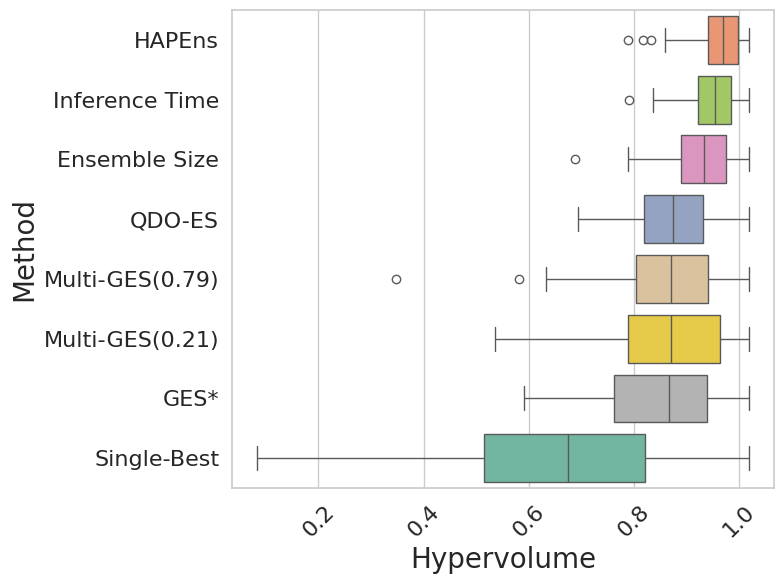

In [9]:
methods = df["method_name"].unique()
all_hypervolumes = {}

for method in methods:
    all_hypervolumes[method] = calculate_average_hypervolumes(df, method, objectives)    

plot_hypervolumes(all_hypervolumes)
hypervolumes_df = pd.DataFrame(all_hypervolumes)
hypervolumes_df.to_csv("../data/hypervolumes.csv", index=False)

In [10]:
data = []
for method, tasks in all_hypervolumes.items():
    for task_id, hypervolume in tasks.items():
        data.append({"Task": task_id, "Method": method, "Hypervolume": hypervolume})

df_hypervolumes = pd.DataFrame(data)
pivot_hypervolumes = df_hypervolumes.pivot(
    index="Task", columns="Method", values="Hypervolume"
)

# Now you can use the modified cd_evaluation function
hv_result = cd_evaluation(
    pivot_hypervolumes,
    maximize_metric=True,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDPHypervolumes.pdf",
)
hv_result = cd_evaluation(
    pivot_hypervolumes,
    maximize_metric=True,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDPHypervolumes.png",
)
print(hv_result)

RankResult(rankdf=
                 meanrank    median       mad  ci_lower  ci_upper effect_size  \
Method                                                                          
HAPEns           2.325301 -0.969760  0.028603 -0.992939 -0.944525         0.0   
Inference Time   2.716867 -0.955536  0.031695 -0.980751 -0.925295   -0.317804   
Ensemble Size    3.548193 -0.933233  0.042741 -0.973506 -0.896888   -0.677474   
Multi-GES(0.21)  4.656627 -0.870696  0.087158 -0.947137 -0.791276   -1.030125   
GES*             4.933735 -0.867014  0.090275 -0.931281 -0.772901   -1.034942   
Multi-GES(0.79)  5.030120 -0.870698  0.068524 -0.926663 -0.806054   -1.272557   
QDO-ES           5.174699 -0.874714  0.055988 -0.916367 -0.825356   -1.442036   
Single-Best      7.614458 -0.674616  0.155983  -0.78316 -0.522114   -1.775276   

                  magnitude  
Method                       
HAPEns           negligible  
Inference Time        small  
Ensemble Size        medium  
Multi-GES(0.21)     

/home/jannis/Projects/HA-ES/.venv/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/home/jannis/Projects/HA-ES/.venv/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/home/jannis/Projects/HA-ES/.venv/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

### Inverted Generational Distance

In [11]:
from pymoo.indicators.igd import IGD

def calculate_IGD_per_method(df, objectives):
    """
    Calculate the IGD for each method_name per task_id, seed, and fold.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of two objective column names.

    Returns:
    - DataFrame with columns [task_id, seed, fold, method_name, IGD].
    """
    results = []

    # Iterate over unique task_ids
    for task_id in df["task_id"].unique():
        # Iterate over unique seeds
        for seed in df["seed"].unique():
            # Iterate over unique folds
            for fold in df["fold"].unique():
                # Filter the DataFrame for the current task_id, seed, and fold
                df_fold = df[
                    (df["task_id"] == task_id)
                    & (df["seed"] == seed)
                    & (df["fold"] == fold)
                ]

                if df_fold.empty:
                    continue  # Skip if no data for this combination

                # Compute the reference Pareto front (from all methods)
                is_efficient = getParetoFront(df_fold, objectives, return_mask=True)
                reference_pareto_front = df_fold[is_efficient]
                pf_points = reference_pareto_front[objectives].values

                # Iterate over unique method_names
                for method_name in df_fold["method_name"].unique():
                    df_method = df_fold[df_fold["method_name"] == method_name]

                    # Compute Pareto front for df_method
                    is_efficient = getParetoFront(df_method, objectives, return_mask=True)
                    method_pareto_front = df_method[is_efficient]
                    method_points = method_pareto_front[objectives].values

                    if len(method_points) == 0 or len(pf_points) == 0:
                        igd_value = np.nan
                    else:
                        # Calculate IGD
                        ind = IGD(pf_points)
                        igd_value = ind(method_points)

                    # Append results
                    results.append({
                        "task_id": task_id,
                        "seed": seed,
                        "fold": fold,
                        "method_name": method_name,
                        "IGD": igd_value
                    })

    return pd.DataFrame(results)


def plot_IGD_values_with_medians(igd_results):
    """
    Plot the IGD values for each method, sorted by median IGD, and annotate the median values on the plot.

    Parameters:
    - igd_results: DataFrame with columns [task_id, seed, fold, method_name, IGD].
    """
    # Remove any NaN IGD values
    igd_results_clean = igd_results.dropna(subset=['IGD'])

    # Compute median IGD per method and sort methods
    median_igd = igd_results_clean.groupby('method_name')['IGD'].median().sort_values()
    sorted_methods = median_igd.index.tolist()

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=igd_results_clean, x='method_name', y='IGD', order=sorted_methods)
    
    # Annotate median values on top of the box plots
    for method in sorted_methods:
        median_val = median_igd[method]
        x = sorted_methods.index(method)  # Find the position on the x-axis
        y = median_val
        ax.text(x, y + 0.01, f'{median_val:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

    plt.title('IGD Values per Method (Sorted by Median IGD)')
    plt.ylabel('IGD')
    plt.xlabel('Method Name')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


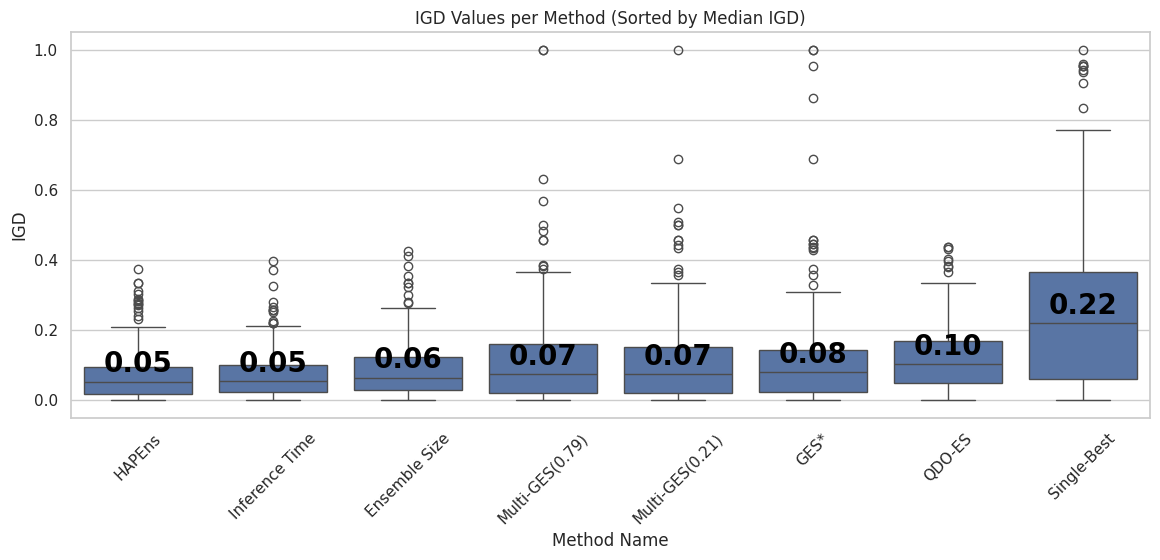

In [12]:
# Calculate IGD per method
igd_results = calculate_IGD_per_method(df, objectives)

# Plot IGD values per method, sorted by median IGD, and annotate median values
plot_IGD_values_with_medians(igd_results)


In [13]:
# Group by 'method_name' and 'task_id', and aggregate with 'sum'
agg_igd = igd_results.groupby(["method_name", "task_id"]).agg('sum').reset_index()

# Pivot the data to have 'task_id' as the index and 'method_name' as columns
igd_pivots = agg_igd.pivot(
    index="task_id", columns="method_name", values="IGD"
)

# Perform the critical difference evaluation
igd_result = cd_evaluation(
    igd_pivots,
    maximize_metric=False,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDP_IGD.png",
)

# Repeat the same evaluation if necessary
igd_result = cd_evaluation(
    igd_pivots,
    maximize_metric=False,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDP_IGD.pdf",
)

/home/jannis/Projects/HA-ES/.venv/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/home/jannis/Projects/HA-ES/.venv/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/home/jannis/Projects/HA-ES/.venv/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

### Pareto Front Topography

/tmp/ipykernel_116678/3812642596.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(['method_name', 'task_id', 'seed', 'fold']).size().reset_index(name='total_solutions')
/tmp/ipykernel_116678/3812642596.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_116678/3812642596.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


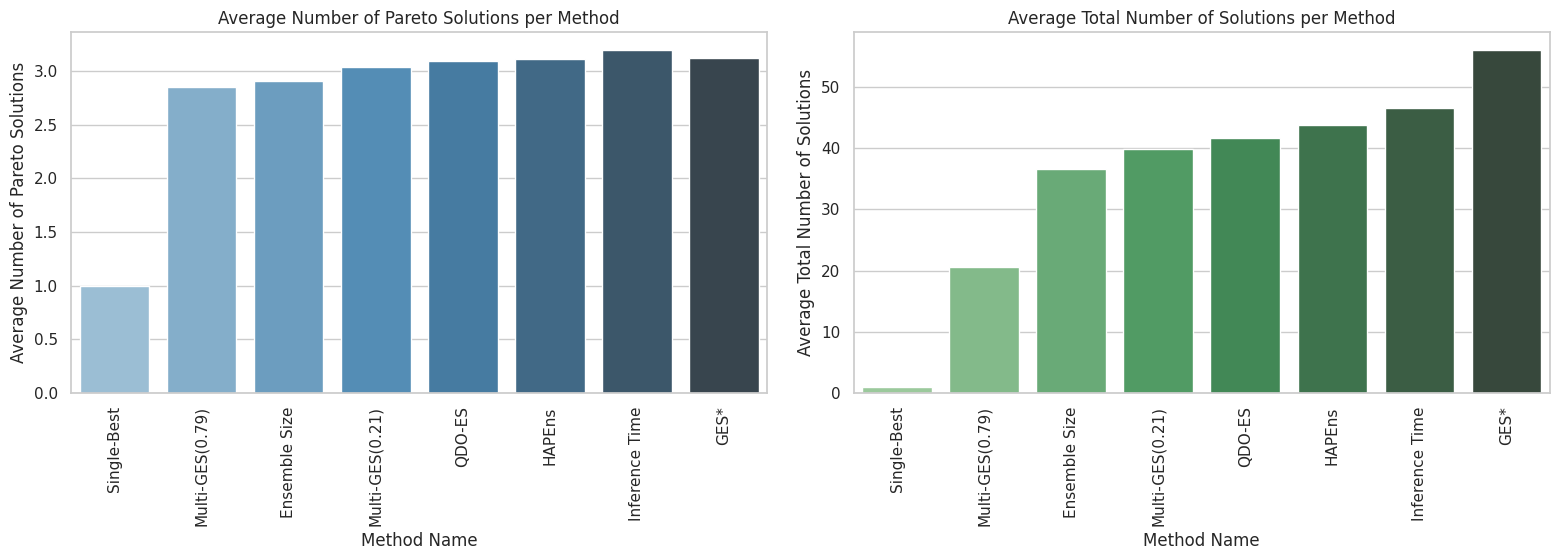

In [14]:
# Get unique method names
method_names = df["method_name"].unique()

# Calculate Pareto fronts for each method
method_pareto_fronts = {}
for method in method_names:
    df_method = df[df["method_name"] == method]
    method_pareto_fronts[method] = calculate_pareto_fronts(df_method, objectives)

# Function to count the number of solutions in Pareto fronts
def count_pareto_solutions(pareto_fronts):
    counts = {}
    for task_id in pareto_fronts:
        for seed in pareto_fronts[task_id]:
            for fold in pareto_fronts[task_id][seed]:
                pareto_front_df = pareto_fronts[task_id][seed][fold]
                n_solutions = len(pareto_front_df)
                key = (task_id, seed, fold)
                counts[key] = n_solutions
    return counts

# Count solutions in the method-specific Pareto fronts
method_pareto_counts = {}
for method in method_names:
    method_pareto_counts[method] = count_pareto_solutions(method_pareto_fronts[method])

# Calculate total number of solutions per method, task_id, seed, fold
total_counts = df.groupby(['method_name', 'task_id', 'seed', 'fold']).size().reset_index(name='total_solutions')

# Prepare data for plotting counts
data_list = []

# Add the method-specific Pareto fronts and total counts
for method in method_names:
    counts = method_pareto_counts[method]
    for key, n_solutions in counts.items():
        task_id, seed, fold = key
        # Get total number of solutions for this method, task_id, seed, fold
        total_solutions = total_counts[
            (total_counts['method_name'] == method) &
            (total_counts['task_id'] == task_id) &
            (total_counts['seed'] == seed) &
            (total_counts['fold'] == fold)
        ]['total_solutions'].values[0]
        data_list.append({
            'method_name': method,
            'task_id': task_id,
            'seed': seed,
            'fold': fold,
            'n_pareto_solutions': n_solutions,
            'total_solutions': total_solutions
        })

pareto_counts_df = pd.DataFrame(data_list)
pareto_counts_df['proportion_pareto'] = pareto_counts_df['n_pareto_solutions'] / pareto_counts_df['total_solutions']


# Calculate the average number of Pareto solutions per method
avg_pareto_solutions = pareto_counts_df.groupby('method_name')['n_pareto_solutions'].mean().reset_index()

# Calculate the average total number of solutions per method
avg_total_solutions = pareto_counts_df.groupby('method_name')['total_solutions'].mean().reset_index()

# Merge the averages into a single DataFrame
avg_counts_df = pd.merge(avg_pareto_solutions, avg_total_solutions, on='method_name')

# Sort methods by average total solutions for better visualization
avg_counts_df = avg_counts_df.sort_values('total_solutions')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot average number of Pareto solutions
sns.barplot(
    data=avg_counts_df,
    x='method_name',
    y='n_pareto_solutions',
    ax=axes[0],
    palette='Blues_d'
)
axes[0].set_title('Average Number of Pareto Solutions per Method')
axes[0].set_xlabel('Method Name')
axes[0].set_ylabel('Average Number of Pareto Solutions')
axes[0].tick_params(axis='x', rotation=90)

# Plot average total number of solutions
sns.barplot(
    data=avg_counts_df,
    x='method_name',
    y='total_solutions',
    ax=axes[1],
    palette='Greens_d'
)
axes[1].set_title('Average Total Number of Solutions per Method')
axes[1].set_xlabel('Method Name')
axes[1].set_ylabel('Average Total Number of Solutions')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


## Latex Table

In [15]:
def create_latex_table(df, repo, filename="table.tex", max_char=15):
    methods = df["method_name"].unique()
    task_ids = df["task_id"].unique()

    with open(filename, "w") as f:
        f.write("\\begin{longtable}{l" + "c" * len(methods) + "}\n")
        f.write(
            "\\caption{Test ROC AUC - Binary: The mean and standard deviation of the test score over all folds for each method. The best methods per dataset are shown in bold. All methods close to the best method are considered best (using NumPy’s default \\texttt{isclose} function).}\n"
        )
        f.write("\\label{tab:results} \\\\ \n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endfirsthead\n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endhead\n")
        f.write("\\midrule\n")
        f.write(
            "\\multicolumn{"
            + str(len(methods) + 1)
            + "}{r}{Continued on next page} \\\\\n"
        )
        f.write("\\midrule\n")
        f.write("\\endfoot\n")
        f.write("\\bottomrule\n")
        f.write("\\endlastfoot\n")

        for task_id in task_ids:
            dataset_name = repo.tid_to_dataset(
                task_id
            )  # Convert task_id to dataset name
            truncated_name = (
                (dataset_name[:max_char] + "...")
                if len(dataset_name) > max_char
                else dataset_name
            )
            escaped_name = truncated_name.replace("_", "\\_")  # Escape underscores
            line = [str(escaped_name)]  # Ensure the first item is a string
            method_scores = []

            for method in methods:
                method_data = df[
                    (df["task_id"] == task_id) & (df["method_name"] == method)
                ]
                if not method_data.empty:
                    mean_score = method_data["roc_auc_test"].mean()
                    std_dev = method_data["roc_auc_test"].std()
                    score_str = f"{mean_score:.4f}($\\pm${std_dev:.4f})"
                    method_scores.append((mean_score, score_str))
                else:
                    method_scores.append((None, "-"))

            # Determine the best score
            best_score = max(
                score[0] for score in method_scores if score[0] is not None
            )

            for mean_score, score_str in method_scores:
                if mean_score is not None and np.isclose(mean_score, best_score):
                    line.append(f"\\textbf{{{score_str}}}")
                else:
                    line.append(score_str)

            f.write(" & ".join(line) + " \\\\\n")

        f.write("\\bottomrule\n")
        f.write("\\end{longtable}\n")

In [16]:
directory = "../tables"
if not os.path.exists(directory):
    os.makedirs(directory)

repo = load_repository("D244_F3_C1530_100", cache=True)
create_latex_table(df, repo, filename="../tables/table.tex")